<a id='logbook'></a>
# Ship power prediction
Analysis and development of a model to predict ship power.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import sympy as sp

import pandas as pd
import numpy as np

# Unmark for publish quality plots
#if os.name == 'nt':
#    plt.style.use('paper.mplstyle')  # Windows

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp
import seaborn as sns

from copy import deepcopy
import sys
sys.path.append('../../')
from src.notebook_to_latex import Equation, equation_dict
#from src import equations,symbols
import reports.paper_writing
from src.df_to_latex import LateXTable
import src.data.load as load
from src.data.transform import transform
from src.visualization.visualize import plotable_dataframe

import plotly.express as px 
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import xgboost

## Examples:


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')

from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Full-scale measurement data of ship’s propulsion power is analyzed. Various statistics and machine learning models are fitted to predict the propulsion power based on features about the ship operational condition and data about the encountered metocean environments.  

# Introduction

<a id='fig_rolldecay_example>'></a>

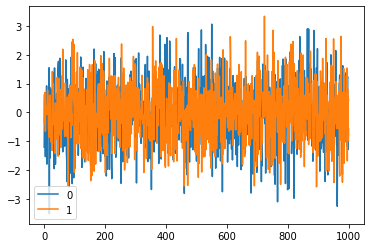

In [4]:
fig,ax=plt.subplots()
df = pd.DataFrame(data=np.random.normal(size=(1000,2)))
df.plot(ax=ax);

The oscillating motion can be described by a spring-mass-damper system as seen in Fig.[(below)](#fig_spring_mass_damper).

This system can me described as the following equation [(below)](#eq_equation1):

<a id="eq_equation1"></a>

In [5]:
eq = r'$E=m \dot c^2 $'
Equation(eq, label='equation1')

<src.notebook_to_latex.Equation object>

In [6]:
A,r = sp.symbols('A r')
eq = sp.Eq(A,
          r**2*sp.pi)
Equation(eq, label='equation2')

<src.notebook_to_latex.Equation object>

# Data
The data used in this study is described in Tab.[(below)](#fig_data_description).

<a id="fig_data_description"></a>

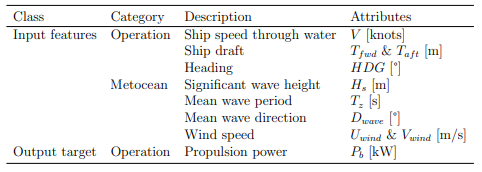

In [7]:
Image('../figures/data_description.PNG')

## Exploratory data analysis
The ship speed $V$, ship draughts $T_{aft}$ and $T_{fwd}$ were all negative in the raw data file. This was imidiatelly corrected, to be more in line with what would be expected from a more general sign convention.

In [8]:
raw_data = load.raw()

In [9]:
display(raw_data.head())
display(raw_data.describe())
display(raw_data.dtypes)

Power          V  T_fwd  T_aft         HDG        Hs        Tz  \
0  4096.859211  23.359333  10.25   10.2  225.120423  0.336355  4.113880   
1  4062.904838  23.351923  10.25   10.2  225.121609  0.334025  4.107303   
2  4105.640943  23.304333  10.25   10.2  213.803859  0.331768  4.100033   
3  4156.401020  23.293167  10.25   10.2  225.124531  0.328743  4.084423   
4  4147.498244  23.287000  10.25   10.2  225.125682  0.326883  4.072262   

      D_wave    U_wind    V_wind  
0  58.287071 -0.251960  0.598855  
1  61.219389 -0.205543  0.537524  
2  64.378446 -0.167395  0.480271  
3  69.095584 -0.153352  0.410798  
4  73.970302 -0.125637  0.360612

Power            V        T_fwd        T_aft          HDG  \
count  8631.000000  8631.000000  8631.000000  8631.000000  8631.000000   
mean   3188.935287    24.278879    11.182685    11.093998   254.571157   
std    1332.289539     1.001131     0.715500     0.701950    70.481649   
min    1000.000000    22.436267    10.250000    10.160000     0.000000   
25%    1815.723938    23.454343    10.700000    10.600000   245.028127   
50%    3173.939254    24.132437    11.000000    10.800000   270.018724   
75%    4385.159249    24.897164    11.700000    11.600000   292.405334   
max    5974.050320    27.955649    12.400000    12.200000   347.212496   

                Hs           Tz       D_wave       U_wind       V_wind  
count  8631.000000  8631.000000  8631.000000  8631.000000  8631.000000  
mean      1.666358     7.462152   204.735041     2.035780     0.747150  
std       0.813212     1.955307    80.514470     4.931660     4.261370  
min       0.158431     2.233657     2.680181   -11.236499   -14.531855  
25%       1.153389     6.396379   169.396098    -0.985087    -2.065295  
50%       1.540236     7.497403   205.961881     2.740314     0.088762  
75%       2.160576     8.980331   268.427660     5.574664     3.568319  
max       4.330742    11.513423   358.097469    13.623467    12.415640

Power     float64
V         float64
T_fwd     float64
T_aft     float64
HDG       float64
Hs        float64
Tz        float64
D_wave    float64
U_wind    float64
V_wind    float64
dtype: object

Fig.[(below)](#fig_heat_map_raw_data) shows a heat map of the absolute linear correlation coefficient between all of the features in the raw data. It can be seen that $T_{aft}$ and $T_{fwd}$ have the highest correlation with the $Power$. It can also be seen that the correlation between $T_{aft}$ and $T_{fwd}$ is also very high (approximately 1) implying a very high multicollinearity which is generally something that should be avoided in regression problems. These two features are instead replaced with the two features: mean draught $T$ and $trim$. The correspondig heat map with the new features is shown in Fig.[(below)](#fig_heat_map_data). The mean draught $T$ now seems to be a very important feature in this regression as it has the highest linear correlation with the $Power$.

<a id="fig_heat_map_raw_data"></a>

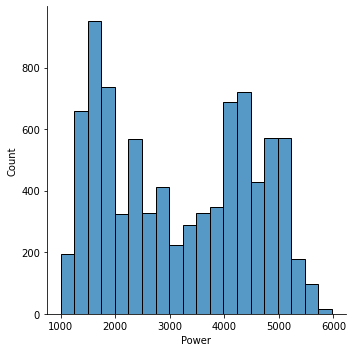

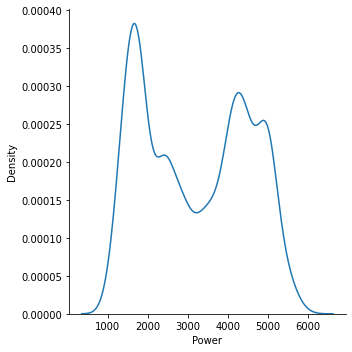

In [10]:
sns.displot(raw_data, x="Power", kind="hist")
sns.displot(raw_data, x="Power", kind="kde", bw_adjust=1)

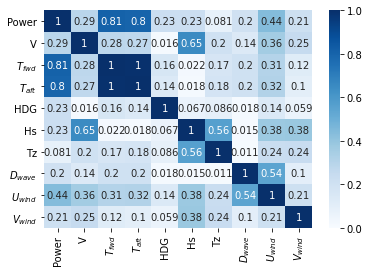

In [11]:
corr = plotable_dataframe(raw_data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<a id="fig_heat_map_data"></a>

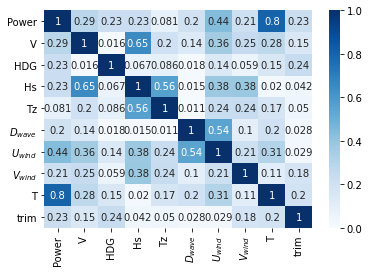

In [12]:
data = transform(raw_data=raw_data)

corr = plotable_dataframe(data.corr().abs())

ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True)
fig = ax.get_figure()

<AxesSubplot:>

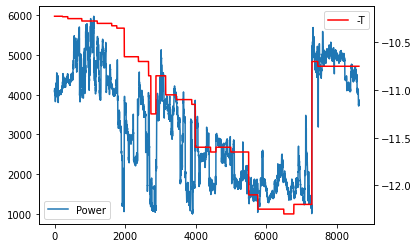

In [13]:
fig,ax=plt.subplots()

data_ = data.copy()
data_.plot(y='Power', ax=ax)
ax2 = ax.twinx()
data_['-T'] = -data_['T']
data_.plot(y='-T', style='r-', ax=ax2)


<AxesSubplot:>

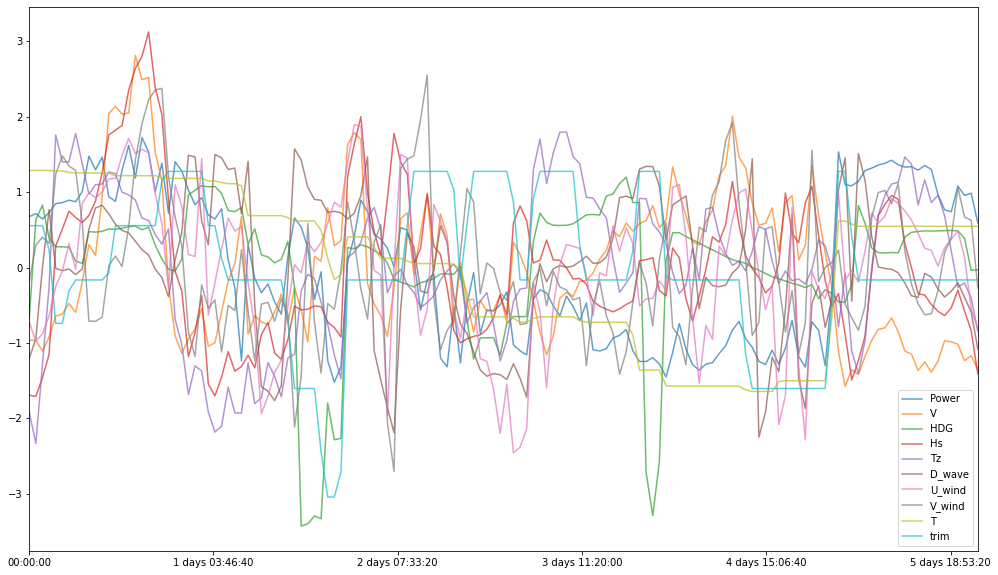

In [14]:
s = StandardScaler()
data_ = s.fit_transform(X=data)
data_ = pd.DataFrame(data_, columns=data.columns, index=data.index)
data_.index = pd.TimedeltaIndex(data_.index, unit='m')
data_ = data_.resample('60min').mean()
data_['T'] = -data_['T']
fig,ax=plt.subplots()
fig.set_size_inches(17,10)
data_.plot(alpha=0.7, ax=ax)

In [15]:
px.line(data_frame=data_, width=1400, height=600,)

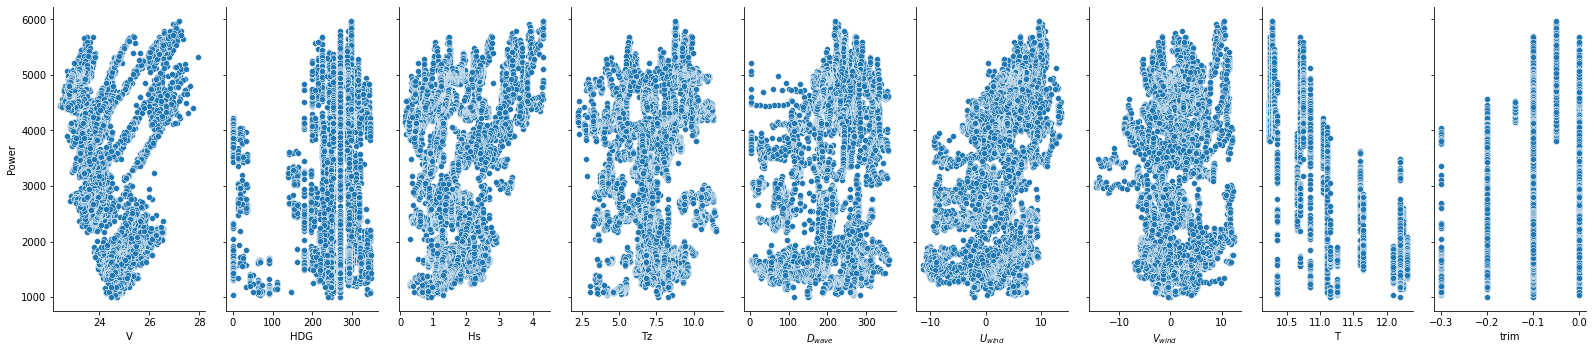

In [16]:
data_plot = plotable_dataframe(data)
x_vars = list(data_plot.columns)
x_vars.remove('Power')

g = sns.PairGrid(data_plot,y_vars='Power', x_vars=x_vars, height=5, aspect=0.5)
g.map_offdiag(sns.scatterplot);

(-1.0, 1.0)

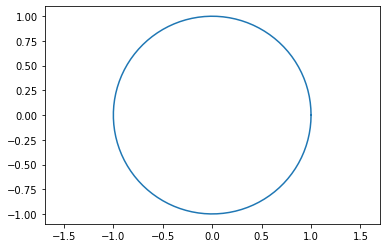

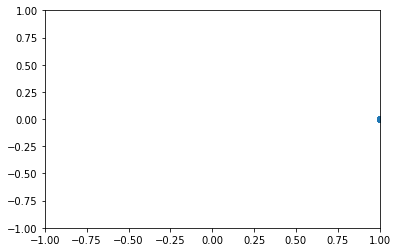

In [17]:
from scipy.spatial.transform import Rotation as R

psi = np.linspace(0,360,100)
r = R.from_euler('z', psi, degrees=True)
coords = r.apply([1,0,0])

fig,ax = plt.subplots()
ax.plot(coords[:,0], coords[:,1],'-');
ax.axis('equal');

r2 = r.inv()
coords = r2.apply(coords)

fig,ax = plt.subplots()
ax.plot(coords[:,0], coords[:,1],'o');
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)




In [18]:

r = R.from_euler('z', data['HDG'], degrees=True)
r2 = r.inv()
#r2 = r

In [19]:
from sympy.vector import CoordSys3D
W = CoordSys3D(name='W')
psi = sp.symbols('psi')
B = W.orient_new_axis('B', psi, W.k)
W.rotation_matrix(B)

Matrix([
[cos(psi), -sin(psi), 0],
[sin(psi),  cos(psi), 0],
[       0,         0, 1]])

In [20]:
## Wind
data['W_wind'] = 0
data[['u_wind','v_wind']] = r2.apply(data[['U_wind','V_wind','W_wind']])[:,0:2]
data.drop(columns=['W_wind'], inplace=True)


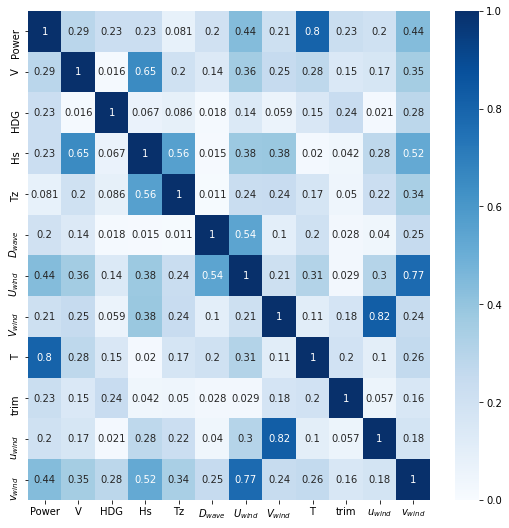

In [21]:
corr = plotable_dataframe(data.corr().abs())
fig,ax = plt.subplots()
fig.set_size_inches(9,9)
ax = sns.heatmap(corr, vmin=0, vmax=1, yticklabels=corr.index, cmap='Blues', annot=True, ax=ax)


# Regression

In [43]:
X = data.copy()
y = X.pop('Power')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

split_index = int(len(X)*0.8)
X_train = X.loc[0:split_index].copy()
y_train = y.loc[0:split_index].copy()

X_test = X.loc[split_index:].copy()
y_test = y.loc[split_index:].copy()


In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(3, 20)}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring='r2')

In [51]:
grid_search.best_params_

{'max_depth': 8}

In [52]:
grid_search.cv_results_['mean_test_score']

array([-1.02640719, -1.04429757, -0.79316056, -0.92004404, -1.23086143,
       -0.79119282, -1.2684636 , -1.10011626, -1.4468725 , -1.0547341 ,
       -1.14596674, -1.3440121 , -1.07867655, -1.10152677, -1.12134804,
       -0.94445448, -1.06319137])

<AxesSubplot:xlabel='param_max_depth'>

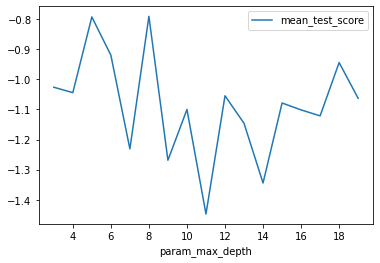

In [53]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.plot(x='param_max_depth', y='mean_test_score', )

In [54]:
model = DecisionTreeRegressor(random_state=42, max_depth=11)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.14698687985517656

In [55]:
feature_importances = pd.Series(data=model.feature_importances_,
                                index=X_train.columns)

<AxesSubplot:>

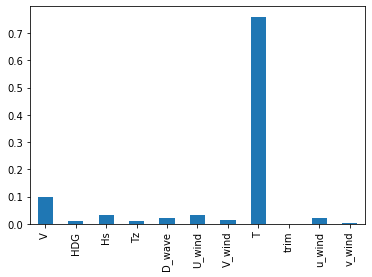

In [56]:
feature_importances.plot(kind='bar')

In [57]:
linear_regression = LinearRegression()
polynomial_features = PolynomialFeatures(degree=3)
standard_scaler = StandardScaler()

steps = [
    ('scaler', standard_scaler),
    ('polynomial_features', polynomial_features),
    ('linear_regression', linear_regression),
]

model_polynomial = Pipeline(steps=steps)

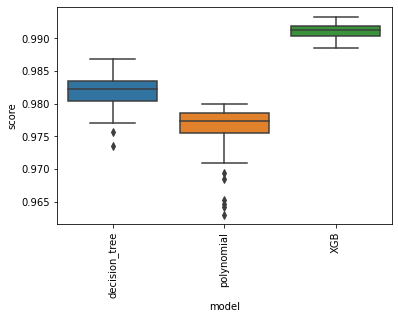

In [63]:
models = {
    'decision_tree': DecisionTreeRegressor(random_state=42, max_depth=11),
    'polynomial':model_polynomial,
    'XGB' : xgboost.XGBRegressor(),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)


cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
scores = {}
for model_name, model in models.items():
    scores[model_name] = cross_val_score(estimator=model, X=X_train, y=y_train, 
                                         scoring='r2', cv=cv, n_jobs=-1)
    
df_cross_validation = pd.DataFrame()

for model_name, model in models.items():

    scores_ = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='r2', cv=cv, n_jobs=-1)
    validations = np.arange(0,len(scores_))
    df_=pd.DataFrame()
    df_['validation']=validations
    df_['score']=scores_
    df_['model']=model_name
    df_cross_validation=df_cross_validation.append(df_, ignore_index=True)

df_scores = pd.DataFrame(scores)

ax = sns.boxplot(x='model', y='score', data=df_cross_validation)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

In [64]:
models['XGB'].fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Validation

In [65]:
models['XGB'].score(X_test, y_test)

0.2562604641014

In [66]:
models['polynomial'].score(X_test, y_test)

0.6383767295488244

In [68]:
models['decision_tree'].score(X_test, y_test)

0.14698687985517656

In [69]:
data_test = X_test.copy()
data_test['Power'] = y_test

keys = []
for model_name, model in models.items():
    key = f'Power_{model_name}'
    data_test[key] = models[model_name].predict(X_test)
    keys.append(key)
    
ys = ['Power'] + keys    
px.line(data_frame=data_test, y = ys, width=1400, height=600,)

# Conclusions
  




# References
<div class="cite2c-biblio"></div>